# Introduction
This tutorial shows how a H2O Deep Learning model can be used to do supervised classification and regression. This tutorial covers usage of H2O from Python. An R version of this tutorial will be available as well in a separate document. This file is available in plain R, R markdown, regular markdown, plain Python and iPython Notebook formats, and the plots are available as PDF files. All documents are available on Github. More examples and explanations can be found in our H2O Deep Learning booklet and on our H2O Github Repository.

## H2O Python Module
Load the H2O Python module.



In [18]:
import h2o

## Start H2O
Start up a 1-node H2O cloud on your local machine, and allow it to use all CPU cores and up to 2GB of memory:



In [19]:
h2o.init(max_mem_size = 2)            #uses all cores by default
h2o.remove_all()                          #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_91"; Java(TM) SE Runtime Environment (build 1.8.0_91-b14); Java HotSpot(TM) 64-Bit Server VM (build 25.91-b14, mixed mode)
  Starting server from /Users/Admin/.local/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/qg/vfkjz6w96f3dmnvmmy18tv200000gn/T/tmp9j8xu_4u
  JVM stdout: /var/folders/qg/vfkjz6w96f3dmnvmmy18tv200000gn/T/tmp9j8xu_4u/h2o_Admin_started_from_python.out
  JVM stderr: /var/folders/qg/vfkjz6w96f3dmnvmmy18tv200000gn/T/tmp9j8xu_4u/h2o_Admin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Oslo
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.6
H2O cluster version age:,1 month and 23 days
H2O cluster name:,H2O_from_python_Admin_x75yio
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [3]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

## H2O Deep Learning
While H2O Deep Learning has many parameters, it was designed to be just as easy to use as the other supervised training methods in H2O. Early stopping, automatic data standardization and handling of categorical variables and missing values and adaptive learning rates (per weight) reduce the amount of parameters the user has to specify. Often, it's just the number and sizes of hidden layers, the number of epochs and the activation function and maybe some regularization techniques.

### Let's have some fun first: Decision Boundaries
We start with a small dataset representing red and black dots on a plane, arranged in the shape of two nested spirals. Then we task H2O's machine learning methods to separate the red and black dots, i.e., recognize each spiral as such by assigning each point in the plane to one of the two spirals.

We visualize the nature of H2O Deep Learning (DL), H2O's tree methods (GBM/DRF) and H2O's generalized linear modeling (GLM) by plotting the decision boundary between the red and black spirals:

Let's get our imports first.



In [4]:
%matplotlib inline                         
#IMPORT ALL THE THINGS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

First, we need to upload our datasets to the the H2O cluster. The data is imported into H2OFrames, which operate similarly in function to pandas DataFrames.

In this case, the cluster is running on our laptops. Data files are imported by their relative locations to this notebook.

In [5]:
import os
spiral = h2o.import_file(path = os.path.realpath("data/spiral.csv"))
grid  = h2o.import_file(path = os.path.realpath("data/grid.csv"))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Spiral is a simple data set consisting of two spirals of black and red dots.
Grid is a 201 by 201 matrix with dimensions [-1.5, 1.5] by [-1.5, 1.5].

To visualize these datasets, we can pull them from H2OFrames into pandas DataFrames for easier plotting.



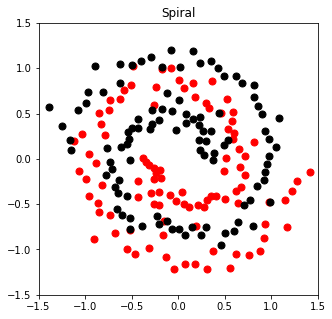

In [6]:
spiral_df = spiral.as_data_frame(use_pandas=True)
grid_df = grid.as_data_frame(use_pandas=True)
grid_x, grid_y = grid_df.x.values.reshape(201,201), grid_df.y.values.reshape(201,201)
spiral_r = spiral_df[spiral_df.color == "Red"]
spiral_k = spiral_df[spiral_df.color == "Black"]

spiral_xr, spiral_yr = spiral_r[spiral_r.columns[0]], spiral_r[spiral_r.columns[1]]
spiral_xk, spiral_yk = spiral_k[spiral_k.columns[0]], spiral_k[spiral_k.columns[1]]
    
markersize_ = 7**2
plt.figure(figsize = (5,5))
plt.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
plt.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title("Spiral");


## Model Construction
H2O in Python is designed to be very similar in look and feel to to scikit-learn. Models are initialized individually with desired or default parameters and then trained on data.

Note that the below examples use model.train(), as opposed the traditional model.fit() This is because h2o-py takes the data frame AND column indices for the feature and response columns, while scikit-learn takes in feature frames.

H2O supports model.fit() so that it can be incorporated into a scikit-learn pipeline, but we advise using train() in all other cases.



In [7]:
X = spiral.col_names[0:2]
y = spiral.col_names[2]
dl_model = H2ODeepLearningEstimator(epochs=1000)
dl_model.train(X, y, spiral)

gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(X, y, spiral)

drf_model = H2ORandomForestEstimator()
drf_model.train(X, y, spiral)

glm_model = H2OGeneralizedLinearEstimator(family="binomial")
glm_model.fit(spiral[X], spiral[y])                                #model.fit() example

models = [dl_model, gbm_model, drf_model, glm_model]
m_names = ["Deep Learning", "Gradient Boosted Method", "Distributed Random Forest", "Generalized Linear Model"]


deeplearning Model Build progress: |██████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


/Users/Admin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: 

	`fit` is not recommended outside of the sklearn framework. Use `train` instead.
  del sys.path[0]


glm Model Build progress: |███████████████████████████████████████████████| 100%


Now that we've trained four models to classify points as red or black based on their (x,y) coordinates.
To see how our models have performed, we ask them to predict the colors of the grid.

Since we'll be doing a lot of spiral plotting, let's write a little helper function to keep things clean.



In [8]:
def plot_spirals(models, model_names):
    fig, ax = plt.subplots(2,2, figsize=(12,12))
    for k, subplot in enumerate(ax.flatten()):
        subplot.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
        subplot.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
        subplot.axis([-1.5, 1.5, -1.5, 1.5])
        subplot.set_title(model_names[k])
        subplot.set_xlabel('x')
        subplot.set_ylabel('y')
        pred_z = models[k].predict(grid).as_data_frame(True)
        subplot.contour(grid_x, grid_y, (pred_z['predict'] == 'Black').astype(np.int).values.reshape(201,201), colors='b')


Below are four graphs of the contour plots of the predictions, so that we can see how exactly the algorithms grouped the points into black and red.


deeplearning prediction progress: |███████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


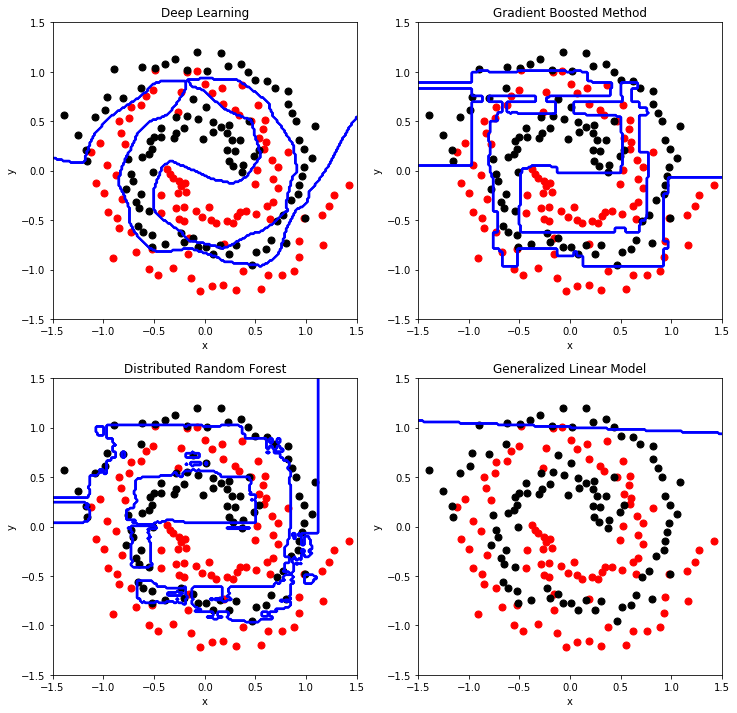

In [9]:
plot_spirals(models, m_names)

## A Deeper Dive into Deep Learning
Now let's explore the evolution of our deep learning model over training time (number of passes over the data, aka epochs).
We will use checkpointing to ensure that we continue training the same model

In [10]:
dl_1 = H2ODeepLearningEstimator(epochs=1)
dl_1.train(X, y, spiral)

dl_250 = H2ODeepLearningEstimator(checkpoint=dl_1, epochs=250)
dl_250.train(X, y, spiral)

dl_500 = H2ODeepLearningEstimator(checkpoint=dl_250, epochs=500)
dl_500.train(X, y, spiral)

dl_750 = H2ODeepLearningEstimator(checkpoint=dl_500, epochs=750)
dl_750.train(X, y, spiral)


deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1539893932132_114


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2978775138925961
RMSE: 0.5457815624337232
LogLoss: 1.1134411896860767
Mean Per-Class Error: 0.33999999999999997
AUC: 0.6537999999999999
Gini: 0.3075999999999999
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00991005745636038: 


,Black,Red,Error,Rate
Black,10.0,90.0,0.9,(90.0/100.0)
Red,0.0,100.0,0.0,(0.0/100.0)
Total,10.0,190.0,0.45,(90.0/200.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0099101,0.6896552,189.0
max f2,0.0099101,0.8474576,189.0
max f0point5,0.6829176,0.6611570,95.0
max accuracy,0.6829176,0.66,95.0
max precision,0.9993233,1.0,0.0
max recall,0.0099101,1.0,189.0
max specificity,0.9993233,1.0,0.0
max absolute_mcc,0.5668226,0.3205776,105.0
max min_per_class_accuracy,0.6725553,0.65,97.0
max mean_per_class_accuracy,0.6829176,0.66,95.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 55.87 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9991874,2.0,2.0,1.0,0.9992757,1.0,0.9992757,0.02,0.02,100.0,100.0
,2,0.02,0.9988764,2.0,2.0,1.0,0.9990411,1.0,0.9991584,0.02,0.04,100.0,100.0
,3,0.03,0.9985463,2.0,2.0,1.0,0.9987916,1.0,0.9990361,0.02,0.06,100.0,100.0
,4,0.04,0.9981868,2.0,2.0,1.0,0.9985028,1.0,0.9989028,0.02,0.08,100.0,100.0
,5,0.05,0.9977595,2.0,2.0,1.0,0.9980069,1.0,0.9987236,0.02,0.1,100.0,100.0
,6,0.1,0.9931438,1.2,1.6,0.6,0.9955889,0.8,0.9971563,0.06,0.16,20.0000000,60.0000000
,7,0.15,0.9893742,0.8,1.3333333,0.4,0.9913436,0.6666667,0.9952187,0.04,0.2,-20.0000000,33.3333333
,8,0.2,0.9783512,0.6,1.15,0.3,0.9848078,0.575,0.9926160,0.03,0.23,-40.0,15.0000000
,9,0.3,0.9435242,1.5,1.2666667,0.75,0.9630283,0.6333333,0.9827534,0.15,0.38,50.0,26.6666667
,10,0.4,0.8519623,1.4,1.3,0.7,0.9123197,0.65,0.9651450,0.14,0.52,40.0000000,30.0000000



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_lift,training_classification_error
,2018-10-18 22:41:35,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2018-10-18 22:41:35,0.038 sec,2333 obs/sec,0.07,1,14.0,0.7070894,5.3864808,-0.9999015,0.4477000,1.0,0.5
,2018-10-18 22:41:35,0.136 sec,2369 obs/sec,1.09,12,218.0,0.5457816,1.1134412,-0.1915101,0.6538000,2.0,0.45


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
x,1.0,1.0,0.5293408
y,0.8891423,0.8891423,0.4706592


deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1539893932132_117


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16260043203132596
RMSE: 0.403237438776865
LogLoss: 0.5133540983206601
Mean Per-Class Error: 0.19499999999999995
AUC: 0.8823000000000001
Gini: 0.7646000000000002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6917505104982437: 


,Black,Red,Error,Rate
Black,80.0,20.0,0.2,(20.0/100.0)
Red,19.0,81.0,0.19,(19.0/100.0)
Total,99.0,101.0,0.195,(39.0/200.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6917505,0.8059701,100.0
max f2,0.2394950,0.8844765,153.0
max f0point5,0.9261929,0.8552632,69.0
max accuracy,0.9141927,0.805,72.0
max precision,1.0000000,1.0,0.0
max recall,0.0241508,1.0,181.0
max specificity,1.0000000,1.0,0.0
max absolute_mcc,0.9141927,0.6335291,72.0
max min_per_class_accuracy,0.7071151,0.8,99.0
max mean_per_class_accuracy,0.6917505,0.805,100.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 61.24 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9999941,2.0,2.0,1.0,0.9999981,1.0,0.9999981,0.02,0.02,100.0,100.0
,2,0.02,0.9999927,2.0,2.0,1.0,0.9999938,1.0,0.9999960,0.02,0.04,100.0,100.0
,3,0.03,0.9999532,2.0,2.0,1.0,0.9999918,1.0,0.9999946,0.02,0.06,100.0,100.0
,4,0.04,0.9999267,2.0,2.0,1.0,0.9999519,1.0,0.9999839,0.02,0.08,100.0,100.0
,5,0.05,0.9991673,2.0,2.0,1.0,0.9998967,1.0,0.9999665,0.02,0.1,100.0,100.0
,6,0.1,0.9950635,2.0,2.0,1.0,0.9974350,1.0,0.9987007,0.1,0.2,100.0,100.0
,7,0.15,0.9918085,1.6,1.8666667,0.8,0.9937493,0.9333333,0.9970503,0.08,0.28,60.0000000,86.6666667
,8,0.2,0.9852652,2.0,1.9,1.0,0.9881419,0.95,0.9948232,0.1,0.38,100.0,90.0000000
,9,0.3,0.9503410,1.7,1.8333333,0.85,0.9697872,0.9166667,0.9864779,0.17,0.55,70.0,83.3333333
,10,0.4,0.8802981,1.5,1.75,0.75,0.9227686,0.875,0.9705505,0.15,0.7,50.0,75.0



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_lift,training_classification_error
,2018-10-18 22:41:36,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2018-10-18 22:41:36,0.343 sec,6430 obs/sec,10.0,1,2000.0,0.6114498,1.4860626,-0.4954834,0.5735,2.0,0.44
,2018-10-18 22:41:41,4.883 sec,10371 obs/sec,250.0,25,50000.0,0.4032374,0.5133541,0.3495983,0.8823000,2.0,0.195


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
y,1.0,1.0,0.5255085
x,0.9029186,0.9029186,0.4744915


deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1539893932132_120


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1663353549267286
RMSE: 0.4078423162531429
LogLoss: 0.5873435335479364
Mean Per-Class Error: 0.21499999999999997
AUC: 0.8773000000000001
Gini: 0.7546000000000002
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6520653683564245: 


,Black,Red,Error,Rate
Black,69.0,31.0,0.31,(31.0/100.0)
Red,12.0,88.0,0.12,(12.0/100.0)
Total,81.0,119.0,0.215,(43.0/200.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6520654,0.8036530,117.0
max f2,0.3122443,0.8974359,144.0
max f0point5,0.9611604,0.8189655,60.0
max accuracy,0.8647701,0.785,81.0
max precision,1.0000000,1.0,0.0
max recall,0.1506193,1.0,158.0
max specificity,1.0000000,1.0,0.0
max absolute_mcc,0.6520654,0.5805757,117.0
max min_per_class_accuracy,0.7844413,0.78,98.0
max mean_per_class_accuracy,0.7878337,0.785,95.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 62.56 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9999999,2.0,2.0,1.0,1.0000000,1.0,1.0000000,0.02,0.02,100.0,100.0
,2,0.02,0.9999997,2.0,2.0,1.0,0.9999999,1.0,0.9999999,0.02,0.04,100.0,100.0
,3,0.03,0.9999994,2.0,2.0,1.0,0.9999996,1.0,0.9999998,0.02,0.06,100.0,100.0
,4,0.04,0.9999987,2.0,2.0,1.0,0.9999992,1.0,0.9999997,0.02,0.08,100.0,100.0
,5,0.05,0.9999974,2.0,2.0,1.0,0.9999986,1.0,0.9999995,0.02,0.1,100.0,100.0
,6,0.1,0.9996164,1.6,1.8,0.8,0.9999202,0.9,0.9999598,0.08,0.18,60.0000000,80.0
,7,0.15,0.9990692,2.0,1.8666667,1.0,0.9994371,0.9333333,0.9997856,0.1,0.28,100.0,86.6666667
,8,0.2,0.9970302,1.8,1.85,0.9,0.9981467,0.925,0.9993759,0.09,0.37,80.0,85.0000000
,9,0.3,0.9644492,1.8,1.8333333,0.9,0.9851313,0.9166667,0.9946277,0.18,0.55,80.0,83.3333333
,10,0.4,0.8719863,1.3,1.7,0.65,0.9197018,0.85,0.9758962,0.13,0.68,30.0000000,70.0



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_lift,training_classification_error
,2018-10-18 22:41:41,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2018-10-18 22:41:42,0.622 sec,3448 obs/sec,10.0,1,2000.0,0.5374016,0.9267593,-0.1552019,0.6496,2.0,0.445
,2018-10-18 22:41:47,5.569 sec,18125 obs/sec,500.0,50,100000.0,0.4078423,0.5873435,0.3346586,0.8773000,2.0,0.215


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
x,1.0,1.0,0.5094588
y,0.9628671,0.9628671,0.4905412


deeplearning Model Build progress: |██████████████████████████████████████| 100%


You can see how the network learns the structure of the spirals with enough training time.

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


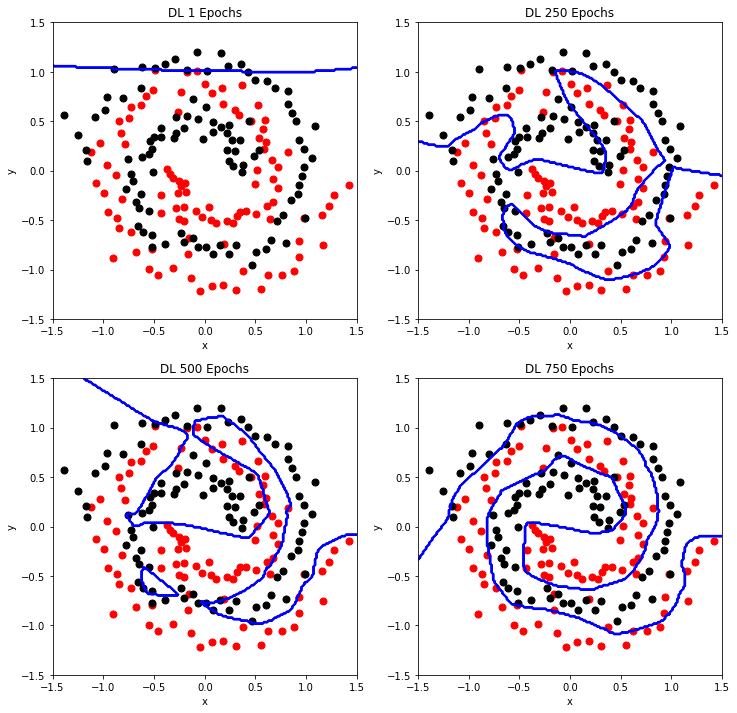

In [11]:
models_dl = [dl_1, dl_250, dl_500, dl_750]
m_names_dl = ["DL " + str(int(model.get_params()['epochs']['actual_value'])) + \
                                     " Epochs" for model in models_dl]

plot_spirals(models_dl, m_names_dl)

## Deep Learning Network Architecture
Of course, there is far more to constructing Deep Learning models than simply having them run longer.
Consider the four following setups.

* Single layer, 1000 nodes
* Two layers, 200 nodes each
* Three layers, 42 nodes each
* Four layers, 11 -> 13 -> 17 -> 19

The H2O Architecture uses the hidden keyword to control model network architecture.
Hidden takes a list of integers, representing the number of nodes in each layer.



In [12]:
dl_1 = H2ODeepLearningEstimator(hidden=[1000], epochs=500)
dl_1.train(X, y, spiral)

dl_2 = H2ODeepLearningEstimator(hidden=[200,200], epochs=500)
dl_2.train(X, y, spiral)

dl_3 = H2ODeepLearningEstimator(hidden=[42,42,42], epochs=500)
dl_3.train(X, y, spiral)

dl_4 = H2ODeepLearningEstimator(hidden=[11,13,17,19], epochs = 1000)
dl_4.train(X, y, spiral)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


It is clear that different configurations can achieve similar performance, and that tuning will be required for optimal performance.

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


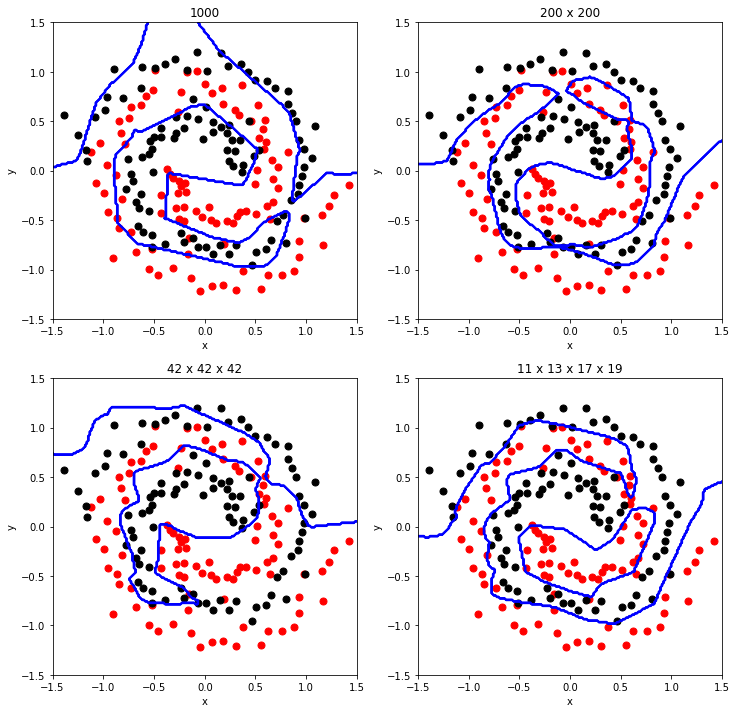

In [13]:
models_network = [dl_1, dl_2, dl_3, dl_4]
m_names_network = ["1000", "200 x 200", "42 x 42 x 42", "11 x 13 x 17 x 19"]

plot_spirals(models_network, m_names_network)


## Activation Functions
Next, we compare between different activation functions, including one with 50% dropout regularization in the hidden layers:

In [14]:
models_act = []
m_names_act = []
for i,method in enumerate(["Tanh","Maxout","Rectifier","RectifierWithDropout"]):
    models_act.append(H2ODeepLearningEstimator(activation=method, hidden=[100,100], epochs=1000))
    models_act[i].train(X, y, spiral)
    m_names_act.append("DL "+ method + " Activation")


deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


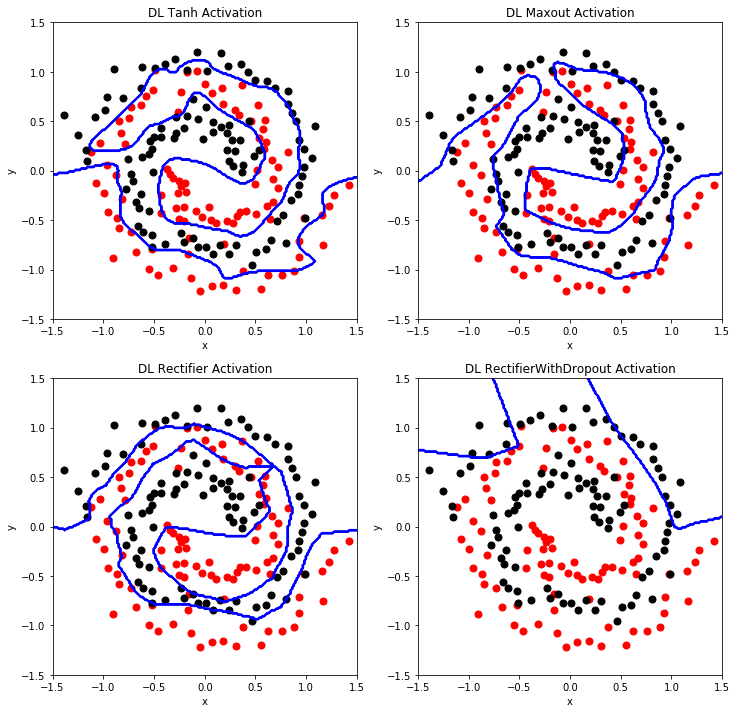

In [15]:
plot_spirals(models_act, m_names_act)

Clearly, the dropout rate was too high or the number of epochs was too low for the last configuration, which often ends up performing the best on larger datasets where generalization is important.

More information about the parameters can be found in the H2O Deep Learning booklet.
# Covertype Dataset
The following examples use the Covertype dataset from UC Irvine, which concerns predicting forest cover based on cartographical data.
We import the full covertype dataset (581k rows, 13 columns, 10 numerical, 3 categorical) and then split the data 3 ways:

* 60% for training
* 20% for validation (hyper parameter tuning)
* 20% for final testing

We will train a data set on one set and use the others to test the validity of the model by ensuring that it can predict accurately on data the model has not been shown.

The second set will be used for validation most of the time.

The third set will be withheld until the end, to ensure that our validation accuracy is consistent with data we have never seen during the iterative process.




In [20]:
covtype_df = h2o.import_file(path = os.path.realpath("data/covtype.full.csv"))

#split the data as described above
train, valid, test = covtype_df.split_frame([0.6, 0.2], seed=1234)

#Prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]     #last column is cover_type, 
covtype_y = covtype_df.col_names[-1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


## First Impressions
Let's run our first Deep Learning model on the covtype dataset.
We want to predict the Cover_Type column, a categorical feature with 7 levels, and the Deep Learning model will be tasked to perform (multi-class) classification. It uses the other 12 predictors of the dataset, of which 10 are numerical, and 2 are categorical with a total of 44 levels.

We can expect the Deep Learning model to have 56 input neurons (after automatic one-hot encoding). First run will be only one epoch to get a feel for the model construction.



In [21]:
#set the model_id for easy lookup in Flow
covtype_model_v1 = H2ODeepLearningEstimator(model_id="covtype_v1", epochs=1, variable_importances=True)
covtype_model_v1.train(covtype_X, covtype_y, training_frame = train, validation_frame = valid)
print(covtype_model_v1)


deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  covtype_v1


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.14313138122057453
RMSE: 0.378327082325036
LogLoss: 0.46197083499602437
Mean Per-Class Error: 0.39755319529274
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
2668.0,938.0,3.0,0.0,1.0,3.0,26.0,0.2668315,"971 / 3,639"
356.0,4467.0,65.0,0.0,4.0,18.0,3.0,0.0907796,"446 / 4,913"
0.0,33.0,564.0,3.0,0.0,17.0,0.0,0.0858995,53 / 617
0.0,0.0,22.0,22.0,0.0,0.0,0.0,0.5,22 / 44
5.0,125.0,2.0,0.0,27.0,1.0,0.0,0.83125,133 / 160
0.0,44.0,179.0,4.0,0.0,80.0,0.0,0.7394137,227 / 307
82.0,15.0,0.0,0.0,0.0,0.0,264.0,0.2686981,97 / 361
3111.0,5622.0,835.0,29.0,32.0,119.0,293.0,0.1941042,"1,949 / 10,041"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.8058958
2,0.9813764
3,0.9974106
4,0.9994024
5,0.9999999
6,0.9999999
7,0.9999999



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.1438641752524849
RMSE: 0.3792943121805083
LogLoss: 0.4673553500555756
Mean Per-Class Error: 0.39196350860034634
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
31281.0,10825.0,12.0,0.0,0.0,16.0,366.0,0.2639765,"11,219 / 42,500"
4218.0,51122.0,662.0,4.0,40.0,302.0,32.0,0.0932600,"5,258 / 56,380"
0.0,447.0,6481.0,59.0,0.0,156.0,0.0,0.0926781,"662 / 7,143"
0.0,0.0,264.0,293.0,0.0,5.0,0.0,0.4786477,269 / 562
59.0,1385.0,77.0,0.0,332.0,17.0,0.0,0.8224599,"1,538 / 1,870"
10.0,587.0,1852.0,34.0,0.0,981.0,0.0,0.7168014,"2,483 / 3,464"
1010.0,121.0,0.0,0.0,0.0,0.0,2968.0,0.2759210,"1,131 / 4,099"
36578.0,64487.0,9348.0,390.0,372.0,1477.0,3366.0,0.1944526,"22,560 / 116,018"


Top-7 Hit Ratios: 


k,hit_ratio
1,0.8055474
2,0.9799169
3,0.9971298
4,0.9992243
5,0.9999742
6,1.0
7,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
,2018-10-18 22:47:57,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2018-10-18 22:48:02,7.130 sec,7030 obs/sec,0.1006031,1,35112.0,0.4463830,0.6259876,0.8988276,0.2691963,0.4497471,0.6342653,0.8963173,0.2737937
,2018-10-18 22:48:21,26.734 sec,12307 obs/sec,0.8031116,8,280298.0,0.3783271,0.4619708,0.9273255,0.1941042,0.3792943,0.4673554,0.9262568,0.1944526
,2018-10-18 22:48:32,37.597 sec,11098 obs/sec,1.0027621,10,349979.0,0.3900680,0.4745870,0.9227448,0.2086446,0.3917130,0.4808279,0.9213488,0.2129756
,2018-10-18 22:48:34,39.193 sec,11096 obs/sec,1.0027621,10,349979.0,0.3783271,0.4619708,0.9273255,0.1941042,0.3792943,0.4673554,0.9262568,0.1944526


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Horizontal_Distance_To_Roadways,1.0,1.0,0.0288861
Elevation,0.9982674,0.9982674,0.0288360
Wilderness_Area.area_0,0.9845084,0.9845084,0.0284386
Horizontal_Distance_To_Fire_Points,0.9018071,0.9018071,0.0260496
Wilderness_Area.area_1,0.8523892,0.8523892,0.0246222
---,---,---,---
Slope,0.4870772,0.4870772,0.0140697
Hillshade_3pm,0.4711398,0.4711398,0.0136094
Aspect,0.3396424,0.3396424,0.0098109
Soil_Type.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()



Inspect the model in Flow for more information about model building etc.

Enter getModel "covtype_v1" into a cell and run in place pressing Ctrl-Enter. Alternatively, you can click on the Models tab, select List All Models, and click on the model named "covtype_v1" as specified in our model construction above.

## Variable Importances
Variable importances for Neural Network models are notoriously difficult to compute, and there are many pitfalls. H2O Deep Learning has implemented the method of Gedeon, and returns relative variable importances in descending order of importance.

Note that we have exactly 56 input neurons, as expected



In [22]:
var_df = pd.DataFrame(covtype_model_v1.varimp(), 
             columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
print(var_df.shape)
var_df.head(10)


(56, 4)


,Variable,Relative Importance,Scaled Importance,Percentage
0,Horizontal_Distance_To_Roadways,1.000000,1.000000,0.028886
1,Elevation,0.998267,0.998267,0.028836
2,Wilderness_Area.area_0,0.984508,0.984508,0.028439
3,Horizontal_Distance_To_Fire_Points,0.901807,0.901807,0.026050
4,Wilderness_Area.area_1,0.852389,0.852389,0.024622
5,Wilderness_Area.area_3,0.831448,0.831448,0.024017
6,Wilderness_Area.area_2,0.811195,0.811195,0.023432
7,Soil_Type.type_23,0.793534,0.793534,0.022922
8,Soil_Type.type_29,0.771099,0.771099,0.022274
9,Soil_Type.type_30,0.754263,0.754263,0.021788


## Early Stopping
Now we run another, smaller network and we let it stop automatically once the misclassification rate converges (specifically if the moving average of length 2 does not improve by at least 1% for 2 consecutive scoring events).

We also sample the validation set to 10,000 rows for faster scoring.



In [23]:
covtype_model_v2 = H2ODeepLearningEstimator(
    model_id="covtype_v2", 
    hidden=[32,32,32],                  ## small network, runs faster
    epochs=1000000,                      ## hopefully converges earlier...
    score_validation_samples=10000,      ## sample the validation dataset (faster)
    stopping_rounds=2,
    stopping_metric="misclassification", ## alternatives: "MSE","logloss","r2"
    stopping_tolerance=0.01)
covtype_model_v2.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)


deeplearning Model Build progress: |██████████████████████████████████████| 100%


To look at the scoring history, we can look up our new model in Flow.

Alternatively, we can use the score_history method to retrieve the data as a pandas DataFrame.



In [24]:
cov_v2_df = covtype_model_v2.score_history()
cov_v2_df

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
0,,2018-10-18 22:49:54,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-10-18 22:49:55,1.121 sec,101223 obs/sec,0.285965,1,99806.0,0.441899,0.607621,0.901066,0.2649,0.441635,0.606941,0.899958,0.262409
2,,2018-10-18 22:50:00,6.462 sec,127527 obs/sec,2.295039,8,801003.0,0.377679,0.450689,0.927732,0.1920,0.380430,0.459925,0.925765,0.197354
3,,2018-10-18 22:50:06,11.850 sec,129130 obs/sec,4.299967,15,1500753.0,0.360741,0.425822,0.934069,0.1742,0.368107,0.440530,0.930497,0.184622
4,,2018-10-18 22:50:11,16.958 sec,125885 obs/sec,6.019526,21,2100905.0,0.354898,0.412563,0.936188,0.1654,0.361998,0.424532,0.932784,0.174674
5,,2018-10-18 22:50:16,22.503 sec,126185 obs/sec,8.024893,28,2800808.0,0.348732,0.400051,0.938386,0.1625,0.355834,0.414596,0.935054,0.170098
6,,2018-10-18 22:50:22,28.138 sec,125976 obs/sec,10.031093,35,3501002.0,0.344408,0.397792,0.939904,0.1588,0.352034,0.409479,0.936434,0.163931
7,,2018-10-18 22:50:28,33.829 sec,125632 obs/sec,12.036102,42,4200780.0,0.338669,0.387338,0.941890,0.1505,0.353071,0.410738,0.936059,0.165423
8,,2018-10-18 22:50:33,39.060 sec,124309 obs/sec,13.752117,48,4799695.0,0.338496,0.395734,0.941949,0.1548,0.347942,0.412433,0.937903,0.163533
9,,2018-10-18 22:50:38,44.143 sec,123718 obs/sec,15.472656,54,5400189.0,0.334993,0.374681,0.943145,0.1478,0.346348,0.393193,0.938471,0.159753


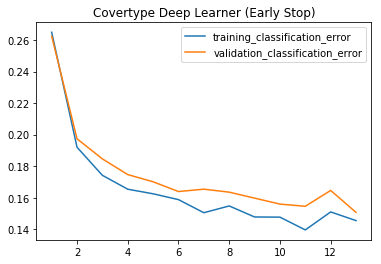

In [25]:
plt.plot(cov_v2_df['training_classification_error'], label="training_classification_error")
plt.plot(cov_v2_df['validation_classification_error'], label="validation_classification_error")
plt.title("Covertype Deep Learner (Early Stop)")
plt.legend();


## Adaptive Learning Rate
By default, H2O Deep Learning uses an adaptive learning rate (ADADELTA) for its stochastic gradient descent optimization. There are only two tuning parameters for this method: rho and epsilon, which balance the global and local search efficiencies. rho is the similarity to prior weight updates (similar to momentum), and epsilon is a parameter that prevents the optimization to get stuck in local optima.

Defaults are rho=0.99 and epsilon=1e-8. For cases where convergence speed is very important, it might make sense to perform a few runs to optimize these two parameters (e.g., with rho in c(0.9,0.95,0.99,0.999) and epsilon in c(1e-10,1e-8,1e-6,1e-4)). Of course, as always with grid searches, caution has to be applied when extrapolating grid search results to a different parameter regime (e.g., for more epochs or different layer topologies or activation functions, etc.).

If adaptive_rate is disabled, several manual learning rate parameters become important: rate, rate_annealing, rate_decay,  momentum_start, momentum_ramp, momentum_stable and nesterov_accelerated_gradient, the discussion of which we leave to H2O Deep Learning booklet.

## Tuning
With some tuning, it is possible to obtain less than 10% test set error rate in about one minute. Error rates of below 5% are possible with larger models. Deep tree methods are more effective for this dataset than Deep Learning, as the space needs to be simply be partitioned into the corresponding hyper-space corners to solve this problem.



In [26]:
covtype_model_tuned = H2ODeepLearningEstimator(
  model_id="covtype_tuned",
  overwrite_with_best_model=False,
  hidden=[128,128,128],            # more hidden layers -> more complex interactions
  epochs=10,                       # to keep it short enough
  score_validation_samples=10000,  # downsample validation set for faster scoring
  score_duty_cycle=0.025,          # don't score more than 2.5% of the wall time
  adaptive_rate=False,             # manually tuned learning rate
  rate=0.01, 
  rate_annealing=0.000002,            
  momentum_start=0.2,              # manually tuned momentum
  momentum_stable=0.4, 
  momentum_ramp=10000000, 
  l1=0.00001,                      # add some L1/L2 regularization
  l2=0.00001,
  max_w2=10.                       # helps stability for Rectifier
)
covtype_model_tuned.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)


deeplearning Model Build progress: |██████████████████████████████████████| 100%


Let's compare the training error with the validation and test set errors.



In [27]:
cov_tuned_df = covtype_model_tuned.scoring_history()
cov_tuned_df


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
0,,2018-10-18 22:51:01,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-10-18 22:51:06,5.539 sec,19748 obs/sec,0.286715,1,100068.0,0.422541,0.547132,0.908583,0.238128,0.420469,0.541496,0.909598,0.233887
2,,2018-10-18 22:51:25,24.582 sec,29286 obs/sec,2.005040,7,699789.0,0.331422,0.348769,0.943759,0.147934,0.333632,0.353718,0.943083,0.150420
3,,2018-10-18 22:51:35,33.976 sec,30241 obs/sec,2.864367,10,999707.0,0.304216,0.300998,0.952614,0.123544,0.309479,0.310956,0.951025,0.127202
4,,2018-10-18 22:51:47,46.996 sec,28551 obs/sec,3.725685,13,1300320.0,0.290394,0.275359,0.956822,0.112892,0.299106,0.292943,0.954253,0.117794
5,,2018-10-18 22:52:12,1 min 11.664 sec,28581 obs/sec,5.730430,20,2000006.0,0.268242,0.236209,0.963158,0.097461,0.274771,0.248615,0.961394,0.097578
6,,2018-10-18 22:52:23,1 min 22.444 sec,29791 obs/sec,6.877547,24,2400367.0,0.257216,0.218807,0.966124,0.088104,0.268118,0.238261,0.963241,0.093575
7,,2018-10-18 22:52:32,1 min 31.429 sec,30223 obs/sec,7.738773,27,2700948.0,0.246607,0.201287,0.968861,0.079940,0.258547,0.220324,0.965819,0.088171
8,,2018-10-18 22:52:41,1 min 39.876 sec,30730 obs/sec,8.595321,30,2999896.0,0.245707,0.199183,0.969088,0.081633,0.255459,0.216911,0.966630,0.087670
9,,2018-10-18 22:52:49,1 min 48.265 sec,31195 obs/sec,9.458144,33,3301034.0,0.241718,0.194375,0.970084,0.076854,0.252292,0.209780,0.967453,0.086169


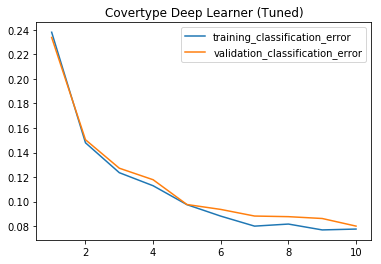

In [28]:
plt.plot(cov_tuned_df['training_classification_error'], label="training_classification_error")
plt.plot(cov_tuned_df['validation_classification_error'], label="validation_classification_error")
plt.title("Covertype Deep Learner (Tuned)")
plt.legend();


In [29]:
pred = covtype_model_tuned.predict(test[0:-1]).as_data_frame(use_pandas=True)
test_actual = test.as_data_frame(use_pandas=True)['Cover_Type']
(test_actual == pred['predict']).mean()

deeplearning prediction progress: |███████████████████████████████████████| 100%


0.9180627527397202

As you can see, we've achieved approximately 90% accuracy on our test data, which is fairly in line with our validation results.

## Shutdown H2O Cluster
This concludes the Python portion of the deeplearning demo.

Shut down the cluster now that we are done using it.



In [ ]:
h2o.cluster().shutdown()